In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lbg_forecast.sfh as sfh
import torchvision
import gpytorch
import torch
from duste.DustAttnCalc import DustAttnCalc
import duste.DustAttnCalc as dd
import lbg_forecast.dust_priors as dp
import scipy as sc

import lbg_forecast.priors_gp_dust as gpdp

In [2]:
ngal = 20000
n, tau, tau1, ne, taue, tau1e, sfr = gpdp.get_nagaraj22_samples(ngal)

Trace file: /Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/duste/TraceFiles/trace_int_logM_logSFR_logZ_z_axis_ratio_n_dust2_msfrlogZzin_d2_map_jp_new_-1_3125_dlw_0.0_eff_0_3125_small.nc
Dat file: /Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/duste/TraceFiles/Interp_logM_logSFR_logZ_z_axis_ratio_n_dust2_msfrlogZzin_d2_map_jp_new_-1_3125_dlw_0.0_eff_0_3125_HB.dat
Measured grid length from file: 5
Mins: {'logM': 8.74, 'sfr': -2.06, 'logZ': -1.7, 'z': 0.51, 'i': 0.09, 'd1': 0.01, 'd2': 0.01, 'de': 0.01}
Maxs: {'logM': 11.3, 'sfr': 2.11, 'logZ': 0.18, 'z': 2.83, 'i': 0.97, 'd1': 2.23, 'd2': 1.95, 'de': 2.19}
Marginalizing over z
Marginalizing over i
Trace file: /Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/duste/TraceFiles/trace_int_dust1_dust2_d1_d2_mapv2_-1_20_dlw_-1.0_eff_0_20.nc
Dat file: /Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/duste/TraceFiles/Interp_dust1_dust2_d1_d2_mapv2_-1_20_dlw_-1.0_eff_0_20_HB.dat
M

In [3]:
nsamples = 500000
recent_sfrs, dust2, dust_index, dust1 = gpdp.get_pop_cosmos_samples(nsamples)

<ErrorbarContainer object of 3 artists>

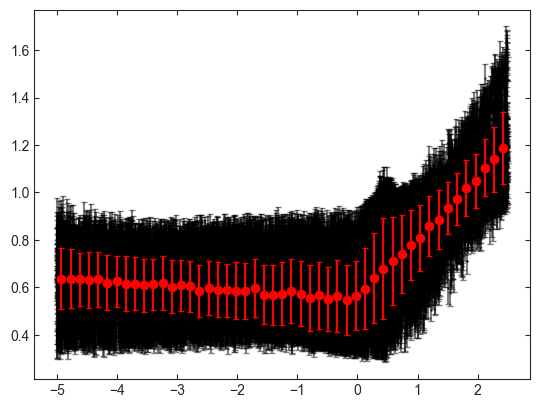

In [4]:
plt.errorbar(sfr, tau, taue, fmt='ko', ms=1, capsize=2, alpha=0.5, zorder=-1)

bin_centers_de, bin_means_de, bin_std_de = gpdp.process_samples(sfr, tau, -5, 2.5, 50)
plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', capsize=2)

<ErrorbarContainer object of 3 artists>

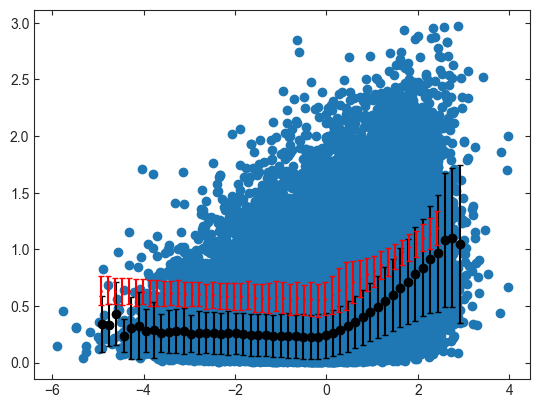

In [5]:
plt.scatter(recent_sfrs, dust2)
bin_centers, bin_means, bin_std = gpdp.process_samples(recent_sfrs, dust2, -5, 3, 50)
plt.errorbar(bin_centers, bin_means, bin_std, fmt='ko', capsize=2)
plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', ms=1, capsize=2)

In [6]:
train_sfrs, train_dust2, train_dust2_errs = gpdp.training_data_to_torch(bin_centers, bin_means, bin_std, bin_centers_de, bin_means_de, bin_std_de)
#avg_err = (bin_std + bin_std_de)/2
#x, y, yerr = gpdp.process_samples(train_sfrs, train_dust2, -4, 2.5, 25)
#plt.errorbar(bin_centers, bin_means, bin_std, fmt='ko', capsize=2, alpha=0.25)
#plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', capsize=2, alpha=0.25)
#plt.errorbar(x, y, yerr, fmt='bo', capsize=2)

In [7]:
#plt.scatter(bin_centers_de, avg_err, c='k')
#a, b, berr = gpdp.process_samples(train_sfrs, train_dust2_errs, -4, 2.5, 40)
#a, b, berr = gpdp.training_data_to_torch(x0, y0, y0err, x, y, yerr)
#plt.errorbar(a, b, berr)
#train_a, train_b, train_berr = torch.from_numpy(a), torch.from_numpy(b), torch.from_numpy(berr)

947.3330775092587
924.904911629566
901.6566783048859
877.6246492581229
852.8522475541705
827.3900236073572
801.2954950168936
774.6328438382791
747.4724706149653
719.8904104533126
691.9676219886157
663.789165100233
635.4432876746397
607.0204453307007
578.6122803718774
550.3105870351817
522.2062893577707
494.3884557996932
466.94337146700536
439.95368499698566
413.49764344421857
387.64842492929205
362.473575251258
338.0345511729771
314.38636988748345
291.57736146094186
269.64901891506673
248.63593906379003
228.56584620616502
209.4596902200984
191.33181041095344
174.19015657078103
158.03655905425492
142.86704026314646
128.67216074484054
115.43739410884257
103.14352603447733
91.76707359228034
81.28072169585808
71.65377352705993
62.85261113258436
54.84116117248114
47.5813593539439
41.033605938875446
35.157204406452195
29.91077617681515
25.25264614703657
21.141196169159734
17.535185872844213
14.394041884690624
11.678117300937473
9.348923310139902
7.369334404650599
5.703767973879676
4.31833848

/Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


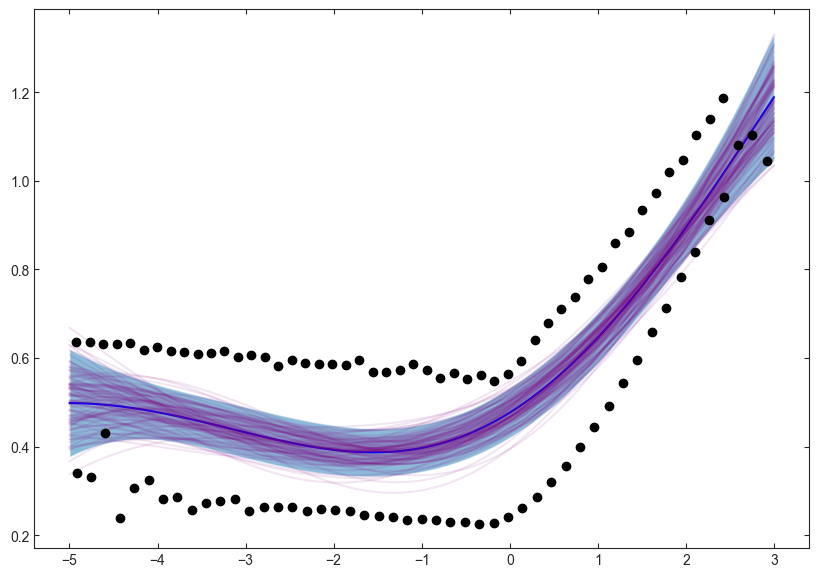

In [8]:
#train_sfrs, train_dust2, train_dust2_errs = torch.from_numpy(x), torch.from_numpy(y), torch.from_numpy(yerr)
test_sfrs = torch.linspace(-5, 3, 100)
trained_model, trained_likelihood = gpdp.train_gp_model_noerr(train_sfrs, train_dust2, [5.0, 15.0], [-100, 100], lr=0.1, training_iter=10000)
f_preds_mu = gpdp.gp_evaluate_model(trained_model, test_sfrs)
gpdp.gp_plot_confidence_obs(f_preds_mu, test_sfrs, train_sfrs, train_dust2, train_dust2_errs*0, labelx="", labely="", alpha=0.5)

for param_name, param in trained_model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')


with torch.no_grad():
    for i in range(100):
        plt.plot(test_sfrs, f_preds_mu.sample().numpy(), c='purple', alpha=0.1)

In [9]:
#mean = np.interp(test_sfrs, train_sfrs, train_dust2)
#with torch.no_grad():
#    for i in range(500):
#        plt.plot(test_sfrs, f_preds_mu.sample().numpy()+mean, c='purple', alpha=0.1)
#    plt.plot(test_sfrs, mean, c='b')
#    lower, upper = f_preds_mu.confidence_region()
#    plt.fill_between(test_sfrs, lower+mean, upper+mean, alpha=0.2)

In [10]:
#test_sfrs = torch.linspace(-4, 3, 100)
#trained_model_sig, trained_likelihood_sig = gpdp.train_gp_model(torch.from_numpy(bin_centers_de), torch.from_numpy(avg_err), torch.from_numpy(avg_err*0), [2.0, 10.0], [-100, 100], lr=0.1, training_iter=10000)
#f_preds_sig = gpdp.gp_evaluate_model(trained_model_sig, test_sfrs)
#gpdp.gp_plot_confidence_obs(f_preds_sig, test_sfrs, torch.from_numpy(bin_centers_de), torch.from_numpy(avg_err), torch.from_numpy(avg_err*0), labelx="", labely="", alpha=0.5)

#for param_name, param in trained_model_sig.named_parameters():
#    print(f'Parameter name: {param_name:42} value = {param.item()}')

#with torch.no_grad():
#    for i in range(500):
#        plt.plot(test_sfrs, f_preds_sig.sample().numpy(), c='purple', alpha=0.1)

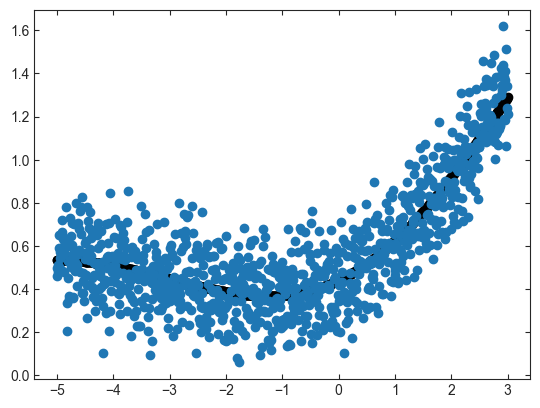

In [11]:
test_sfrs = torch.from_numpy(np.linspace(-5, 3, 1000))
#mean = np.interp(test_sfrs, train_sfrs, train_dust2)
f_preds_mu = gpdp.gp_evaluate_model(trained_model, test_sfrs)
#f_preds_sig = gpdp.gp_evaluate_model(trained_model_sig, test_sfrs)
mean_dust2 = f_preds_mu.sample().numpy()#+mean
#mean_dust2 = np.where(test_sfrs<-1, np.interp(-1, test_sfrs, mean_dust2), mean_dust2)
#sig_dust2 = f_preds_sig.sample().numpy()
#sig_dust2 = np.where(sig_dust2>0.4, 0.4, sig_dust2)
#sig_dust2 = np.where(test_sfrs<-1, 0.2, sig_dust2)
scatter = np.random.uniform(0.1, 0.3)
plt.scatter(test_sfrs, mean_dust2, c='k')
plt.scatter(test_sfrs, dp.truncated_normal(mean_dust2, scatter, 0.0, 4.0, len(test_sfrs)))

In [12]:
torch.save(trained_model.state_dict(), 'gp_models/dust2.pth')

<ErrorbarContainer object of 3 artists>

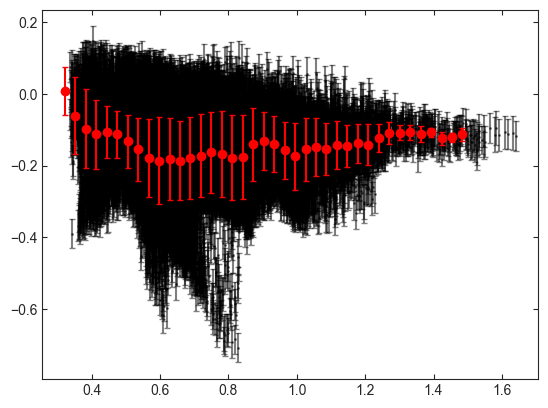

In [13]:
bin_centers_de, bin_means_de, bin_std_de = gpdp.process_samples(tau, n, 0, 1.5, 50)
plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', capsize=2)
plt.errorbar(tau, n, ne, fmt='ko', ms=1, capsize=2, alpha=0.5, zorder=-1)

<ErrorbarContainer object of 3 artists>

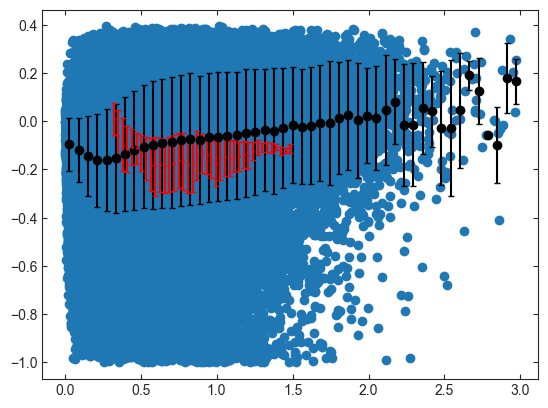

In [14]:
plt.scatter(dust2, dust_index)

bin_centers, bin_means, bin_std = gpdp.process_samples(dust2, dust_index, 0.0, 3.0, 50)

plt.errorbar(bin_centers, bin_means, bin_std, fmt='ko', capsize=2)
plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', ms=1, capsize=2)

In [15]:
train_dust2, train_dust_index, train_dust_index_errs = gpdp.training_data_to_torch(bin_centers, bin_means, bin_std, bin_centers_de, bin_means_de, bin_std_de)
#avg_err = (bin_std + bin_std_de)/2
#x, y, yerr = gpdp.process_samples(train_sfrs, train_dust_index, 0.0, 3.0, 50)
#plt.errorbar(bin_centers, bin_means, bin_std, fmt='ko', capsize=2, alpha=0.25)
#plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', capsize=2, alpha=0.25)
#plt.errorbar(x, y, yerr, fmt='bo', capsize=2)

97.93295737809758
90.43243215769103
82.8873355133867
75.34623893601943
67.86224405633187
60.49249254692392
53.297460911379964
46.340016787140996
39.68421682938245
33.393831758232714
27.530592208541382
22.152160988516304
17.30985545781974
13.046170695727522
9.392192629015248
6.365041956968343
3.9655532165374536
2.1764615715395226
0.961427064838052
0.265246468898419
0.015554721398033685
-0.03241795195365183
-0.08045391577889642
-0.1285703013909639
-0.17672453625377907
-0.2248712938801872
-0.2729625714265602
-0.32094769078132257
-0.3687732387161591
-0.41638295931051617
-0.46371761043659915
-0.5107147952993645
-0.5573087796679206
-0.6034303053685902
-0.6490064107232862
-0.6939602688237235
-0.7382110547837758
-0.7816738534226931
-0.8242596193136297
-0.8658752020372489
-0.9064234512287673
-0.9458034191718596
-0.9839106839072991
-1.0206378235738145
-1.0558750829978145
-1.0895112855564237
-1.1214350550481205
-1.1515364204928735
-1.1797088773589444
-1.205851967476807
-1.2298744134969544
-1.2516

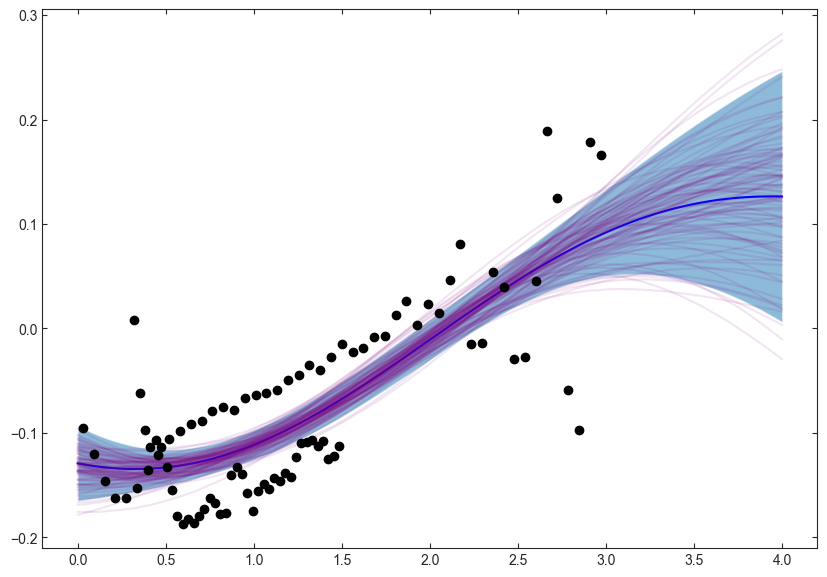

In [16]:
#train_dust2, train_dust_index, train_dust_index_errs = torch.from_numpy(bin_centers), torch.from_numpy(bin_means), torch.from_numpy(bin_std)

test_dust2 = torch.linspace(0, 4, 100)
#train_dust2, train_dust_index, train_dust_index_errs = gpdp.training_data_to_torch(bin_centers, bin_means, bin_std, x, y, yerr)

trained_model, trained_likelihood = gpdp.train_gp_model_noerr(train_dust2, train_dust_index, [2.0, 10.0], [-100, 100], lr=0.1, training_iter=10000)
f_preds = gpdp.gp_evaluate_model(trained_model, test_dust2)
gpdp.gp_plot_confidence_obs(f_preds, test_dust2, train_dust2, train_dust_index, train_dust_index_errs*0, labelx="", labely="", alpha=0.5)
for param_name, param in trained_model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

with torch.no_grad():
    for i in range(100):
        plt.plot(test_dust2, f_preds.sample().numpy(), c='purple', alpha=0.1)

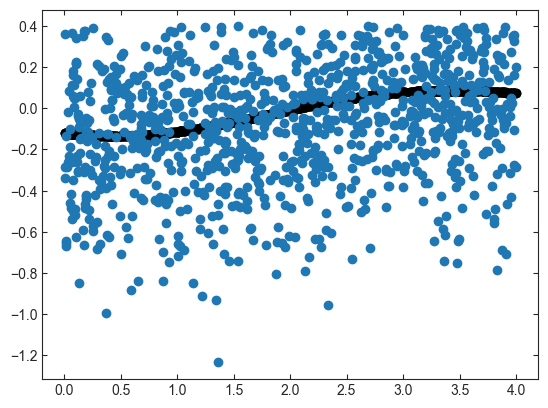

In [17]:
test_tau = torch.from_numpy(np.random.uniform(0, 4, 1000))
f_preds = gpdp.gp_evaluate_model(trained_model, test_tau)
mean_dust_index = f_preds.sample().numpy()
scatter = np.random.uniform(0.1, 0.4)
plt.scatter(test_tau, mean_dust_index, c='k')
plt.scatter(test_tau, dp.truncated_normal(mean_dust_index, scatter, -2.2, 0.4, len(test_tau)))

In [18]:
torch.save(trained_model.state_dict(), 'gp_models/dust_index.pth')

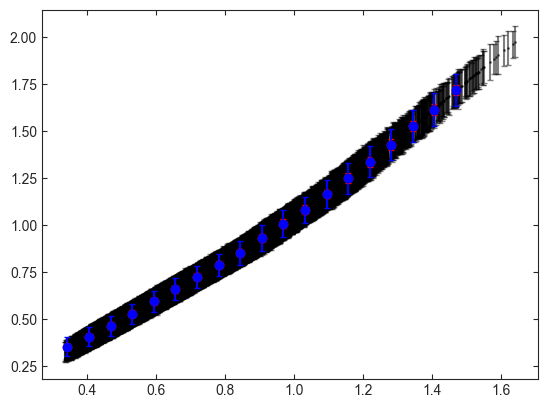

In [34]:
plt.errorbar(tau, tau1, tau1e, fmt='ko', ms=1, capsize=2, alpha=0.5)
bin_centers_de, bin_means_de, bin_std_de = gpdp.process_samples(tau, tau1, 0.0, 1.5, 25)
x, y, yerr = gpdp.process_samples_modified(tau, tau1, tau1e, 0.0, 1.5, 25)
plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', capsize=2)
plt.errorbar(x, y, yerr, fmt='bo', capsize=2)

bin_centers_de, bin_means_de, bin_std_de = x, y, yerr


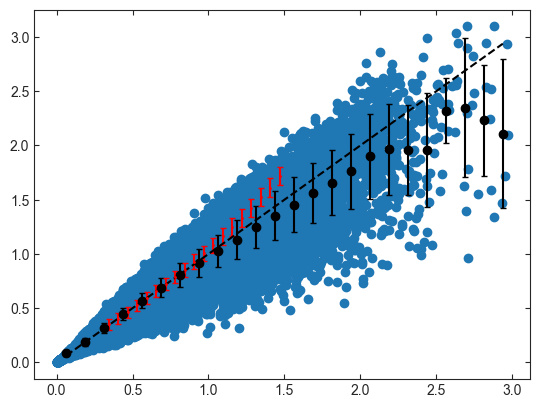

In [35]:
plt.scatter(dust2, dust1)

bin_centers, bin_means, bin_std = gpdp.process_samples(dust2, dust1, 0.0, 3.0, 25)

plt.errorbar(bin_centers, bin_means, bin_std, fmt='ko', capsize=2)
plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', ms=1, capsize=2)
plt.plot(bin_centers, bin_centers, c='k', ls='--')

199.66589884422672
184.35837703467888
168.96076596010286
153.57240426124517
138.30174793770578
123.26553995110069
108.5874969580203
94.3962901573173
80.82303066292431
67.99823874510257
56.04825224557893
45.0910768124109
35.231724884609946
26.557147005017537
19.13093803788844
12.988106589519292
8.130325892202581
4.52222410627542
2.0893890060896574
0.718803750990735
0.2623318074858421
0.21910119076877163
0.17611643482714012
0.13333090374078574
0.09082108678112652
0.04866871395735674
0.006960501649248673
-0.0342118675063002
-0.0747516246747636
-0.11455673469879685
-0.15351972562885105
-0.19152759183832
-0.2284618325443116
-0.26419868879608244
-0.2986096459352344
-0.33156227425805157
-0.3629214868447946
-0.39255129849930925
-0.42031717108566136
-0.44608902511862775
-0.4697449812938273
-0.4911758639888319
-0.5102904464429386
-0.5270213394919313
-0.5413313193268567
-0.5532197557021079
-0.562728648225365
-0.5699476228696002
-0.5750171141414834
-0.5781289028294198
-0.5795232435844295
-0.579482

/Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


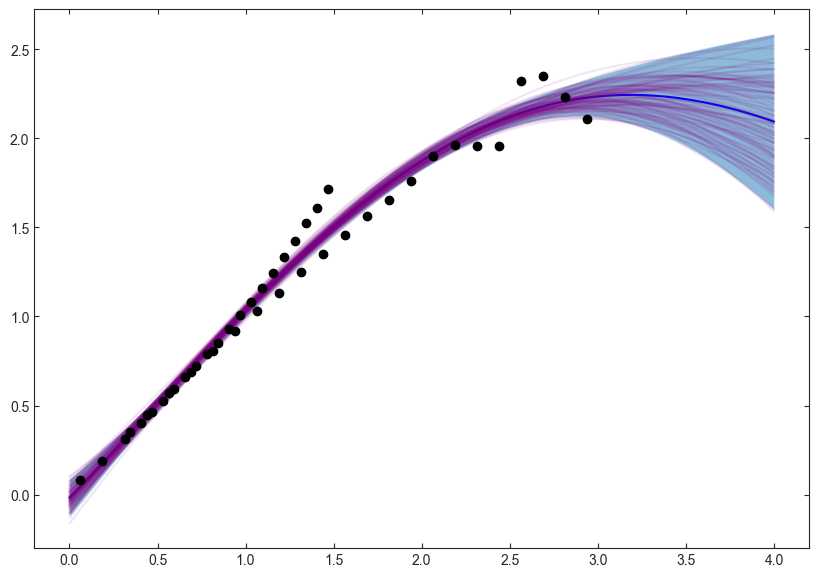

In [36]:
test_dust2 = torch.linspace(0, 4, 100)
train_dust2, train_dust1, train_dust1_errs = gpdp.training_data_to_torch(bin_centers, bin_means, bin_std, bin_centers_de, bin_means_de, bin_std_de)

trained_model, trained_likelihood = gpdp.train_gp_model_noerr(train_dust2, train_dust1, [2.0, 10.0], [-100, 100], lr=0.1, training_iter=10000)
f_preds = gpdp.gp_evaluate_model(trained_model, test_dust2)
gpdp.gp_plot_confidence_obs(f_preds, test_dust2, train_dust2, train_dust1, train_dust1_errs*0, labelx="", labely="", alpha=0.5)
for param_name, param in trained_model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

with torch.no_grad():
    for i in range(100):
        plt.plot(test_dust2, f_preds.sample().numpy(), c='purple', alpha=0.1)

199.61781313651295
184.30762878301783
168.9069583942636
153.51520707392365
138.2410475271158
123.20141903413413
108.52008526841395
94.32570333209445
80.74936370506472
67.92157165143561
55.96865684431287
45.00862260181447
35.14648342704513
26.469194808442516
19.040357946793677
12.894987690537606
8.034761859972292
4.424309815429793
1.9892151675078318
0.6164493447310263
0.15785421612328135
0.1125274602365684
0.0674493163488922
0.022531850646712256
-0.022198355369258238
-0.06671850665014907
-0.11101001266477295
-0.1550580628570065
-0.1988502775746052
-0.24237452390174113
-0.28561620286143846
-0.32855549205961077
-0.37116507020051637
-0.41340870887640746
-0.45524083245481084
-0.49660683286424384
-0.5374437108013098
-0.5776805776217293
-0.6172386949524151
-0.6560309876224786
-0.6939612419264157
-0.7309234000167062
-0.7668014192982513
-0.8014700708949292
-0.8347968444670226
-0.866644885129529
-0.8968766947438241
-0.9253582406274393
-0.9519631407371932
-0.9765767038632045
-0.9990997411977754
-

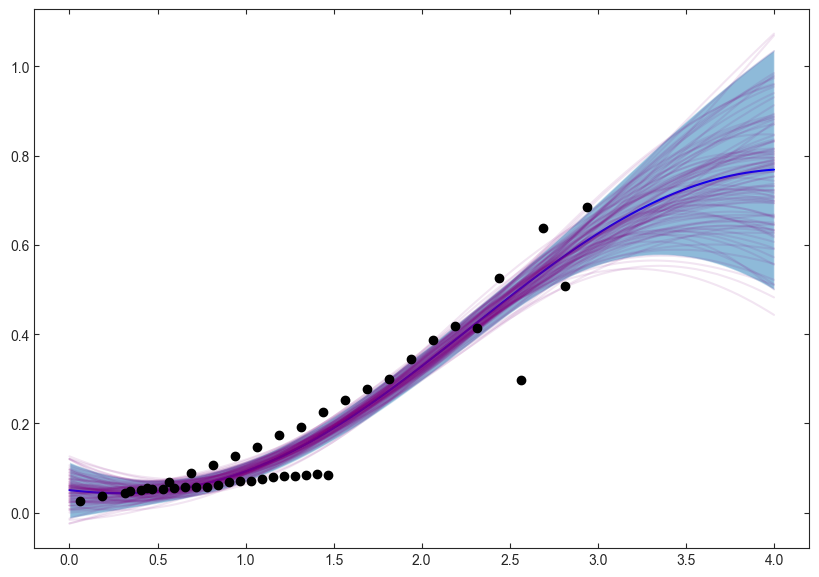

In [37]:
test_dust2 = torch.linspace(0, 4, 100)
train_dust2, train_dust1, train_dust1_errs = gpdp.training_data_to_torch(bin_centers, bin_means, bin_std, bin_centers_de, bin_means_de, bin_std_de)

trained_model_sig, trained_likelihood_sig = gpdp.train_gp_model_noerr(train_dust2, train_dust1_errs, [2.0, 10.0], [-100, 100], lr=0.1, training_iter=10000)
f_preds = gpdp.gp_evaluate_model(trained_model_sig, test_dust2)
gpdp.gp_plot_confidence_obs(f_preds, test_dust2, train_dust2, train_dust1_errs, train_dust1_errs*0, labelx="", labely="", alpha=0.5)
for param_name, param in trained_model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

with torch.no_grad():
    for i in range(100):
        plt.plot(test_dust2, f_preds.sample().numpy(), c='purple', alpha=0.1)

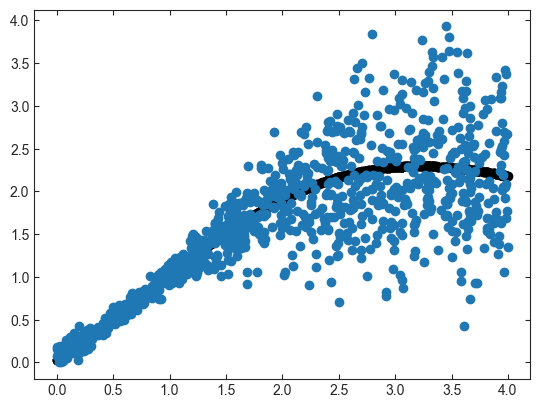

In [54]:
test_tau = torch.from_numpy(np.random.uniform(0, 4, 1000))
f_preds = gpdp.gp_evaluate_model(trained_model, test_tau)
f_preds_sig = gpdp.gp_evaluate_model(trained_model_sig, test_tau)
mean_dust1 = f_preds.sample().numpy()
sig_dust1 = f_preds_sig.sample().numpy()
sig_dust1 = np.where(sig_dust1<0.05, 0.05, sig_dust1)
#scatter = np.random.uniform(0.05, 0.4)
plt.scatter(test_tau, mean_dust1, c='k')
plt.scatter(test_tau, dp.truncated_normal(mean_dust1, sig_dust1, 0.0, 4.0, len(test_tau)))

In [56]:
torch.save(trained_model.state_dict(), 'gp_models/dust1.pth')
torch.save(trained_model_sig.state_dict(), 'gp_models/dust1sig.pth')